# Performance Robustness Evaluation for Statistical Classifiers

## Content

- [Overview](#overview)
- [Exploratory Data Analysis](#eda)
    * [Preview and Pre-processing](#pp)
    * [Univariate Exploration](#ue)
    * [Bivariate Exploration](#be)
- [Classification Models & Metrics Evaluation](#cmme)
    * [K Nearest Neighbors(KNN) Model](#knn)
    * [Logistic Repression Model](#lg)
    * [Multi-layer Perceptron (MLP) Model](#mlp)
- [Conclusions](#conclusion)

<a id='overview'></a>
## Overview
Mozilla is planning to invest more substantially in privacy-preserving machine learning models for applications such as recommending personalized content and detecting malicious behaviour. As such solutions move towards production, it is essential for us to have confidence in the selection of the model and its parameters for a particular dataset, as well as an accurate view into how it will perform in new instances or as the training data evolves.

While the literature contains a broad array of models, evaluation techniques, and metrics, their choice in practice is often guided by convention or convenience, and their sensitivity to different datasets is not always well-understood. Additionally, to our knowledge there is no existing software tool that provides a comprehensive report on the performance of a given model under consideration.

The eventual goal of this project is to build a standard set of tools that Mozilla can use to evaluate the performance of machine learning models in various contexts on the basis of the following principles:

* Holistic view of model performance
  - Eg. evaluating a model in terms of multiple metrics (ie as a battery of tests), and understanding the tradeoffs between them
  * For classification, separating predicted class membership scores from the decision rule assigning a final class
* Stability of performance metrics as an additional metric to optimize for
  * Eg. the variability of performance metrics across difference splits of the dataset
* Generalizability of the model to unseen data
* Explainability/parsimony when possible
* Reproducibility of results
  * Eg. looking for ways to leverage existing public datasets in the evaluation process when the actual data cannot be made public
* Informative failures
  * We can learn a lot by studying the cases where the model performs poorly, eg. misclassifications or cases near the decision boundary
  * Failures may have implications for generalizability, appropriateness of the choice of model, ethical considerations/bias
  * Eg. do we see systematic failures with a homogeneous distribution within themselves but differing from training data.
At this early stage, the focus is on implementing evaluation methodologies in line with these principles, and testing them out across different models and datasets.

<a id='eda'></a>
## Exploratory Data Analysis
<a id='pp'></a>
### Preview and Pre-processing


**Importing libraries**

In [1]:
# Basic Computations
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Ml Models
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Dynamic Markdowns
from IPython.display import Markdown as md

In [2]:
#**Adding module’s sub-directory to Pythons path**
import os
import sys
sys.path.insert(0, os.path.abspath('../elie_wanko/modules'))
import helpers, knn, lg, mlp

**Attribute Information:**

This research employes a binary variable, **C24: default payment (Yes = 1, No = 0)**, as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
* **C1: Amount of the given credit** (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
* **C2: Gender** (1 = male; 2 = female).
* **C3: Education** (1 = graduate school; 2 = university; 3 = high school; 4 = others).
* **C4: Marital status** (1 = married; 2 = single; 3 = others).
* **C5: Age** (year).
* **C6 - C11: History of past payment**. We tracked the past monthly payment records (from April to September, 2005) as follows: 
  * **C6** = the repayment status in September, 2005; 
  * **C7** = the repayment status in August, 2005; 
  * . . .;
  * **C11** = the repayment status in April, 2005. 
  
  >_The measurement scale for the repayment status is:_ 
  * _1 = pay duly;_
  * _1 = payment delay for one month;_
  * _2 = payment delay for two months;_
  * _. . .;_
  * _8 = payment delay for eight months;_ 
  * _9 = payment delay for nine months and above._
* **C12 - C17: Amount of bill statement** (NT dollar). 
  * **C12** = amount of bill statement in September, 2005; 
  * **C13** = amount of bill statement in August, 2005; 
  * _. . .;_ 
  * **C17** = amount of bill statement in April, 2005.
* **C18 - C23: Amount of previous payment** (NT dollar). 
  * **C18** = amount paid in September, 2005; 
  * **C19** = amount paid in August, 2005; 
  * _. . .;_
  * **C23** = amount paid in April, 2005.

**Data Preview**

There are 30,000 rows, all Non-Null and 25 columns in our DataFrame, all of which are of numerical data(int64). The sample table below shows the first 5 columns of our data set and the next shows some basic information of every column (*'column Index', 'column_name', 'Non_Null Counts in each column' and 'data type'*).

In [3]:
df_data = pd.read_csv("../../datasets/defaults.csv")
df_data.head()

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,defaulted
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
df_data.describe()

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,defaulted
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [5]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   id         30000 non-null  int64
 1   limit_bal  30000 non-null  int64
 2   sex        30000 non-null  int64
 3   education  30000 non-null  int64
 4   marriage   30000 non-null  int64
 5   age        30000 non-null  int64
 6   pay_0      30000 non-null  int64
 7   pay_2      30000 non-null  int64
 8   pay_3      30000 non-null  int64
 9   pay_4      30000 non-null  int64
 10  pay_5      30000 non-null  int64
 11  pay_6      30000 non-null  int64
 12  bill_amt1  30000 non-null  int64
 13  bill_amt2  30000 non-null  int64
 14  bill_amt3  30000 non-null  int64
 15  bill_amt4  30000 non-null  int64
 16  bill_amt5  30000 non-null  int64
 17  bill_amt6  30000 non-null  int64
 18  pay_amt1   30000 non-null  int64
 19  pay_amt2   30000 non-null  int64
 20  pay_amt3   30000 non-null  int64
 21  pay_amt4   3

**Data Cleaning**

* The first column(C1) reprensents the client id number and it has no use in determining whether a client will default or not. For this reason, we will drop this column.
* To keep the naming consistent across "History of past payment (C6-C11)", "Amount of bill statement (C12-C17)" and "Amount of previous payment (C18-C23)", we rename C6 from pay_0 to pay_1. This helps facilitate the identifying months especially during plotting graphs.

In [6]:
# Drop column 'id'
df_data = df_data.drop(columns='id')
# Rename C6 from pay_0 to pay_1 for consistency
df_data = df_data.rename(columns={"pay_0": "pay_1"})

* Other cleaning can be done but without more information we will stop here.

**Observations:**

The main feature of data set is **"C24: defaulted"**, this tells us whether a customer defaulted or not. Our variables C1 to C23 will help us support our investigation into the feature of interest above. Some basic statistical details and questions we can pose include:
* A mean value of 1.6 for 'sex' indicates that there are more females than men. Does this mean than women are more prone the default than men?
* Similarly, the mean value of 1.85  for 'education' indicates that most clients are either in graduate school or university. With a value close to 2, we can assume that most of them are in university. The mean value of 35.49years for age, tends to confirm this hypothesis. Question is to shich age group do banks now need to give credits more?
* Last but not the least, the mean value of 'defaulted' column indicates that about 22.12% of clients defaulted.

Next, we further investigate using various distributions to discover more insights and find out if our assumptions are true.

In [7]:
df_data.describe()

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,defaulted
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


<a id='ue'></a>
### Univariate Exploration

In this section, we investigate distributions of individual variables. We note any unusual points or outliers, clean things up and prepare to look at relationships between variables.

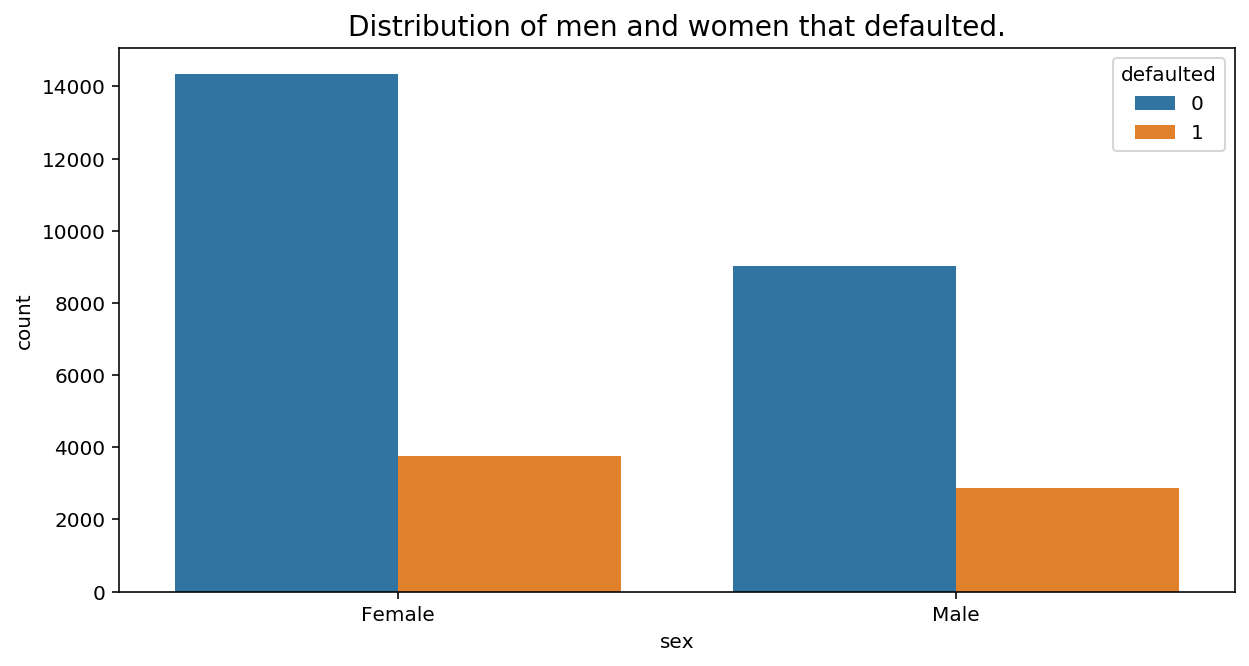

In [8]:
helpers.univ_bar(data=df_data, column='sex', x_title='sex', hue='defaulted', 
                 var_names=['Male', 'Female'], order=True, title="Distribution of men and women that defaulted.")

> 

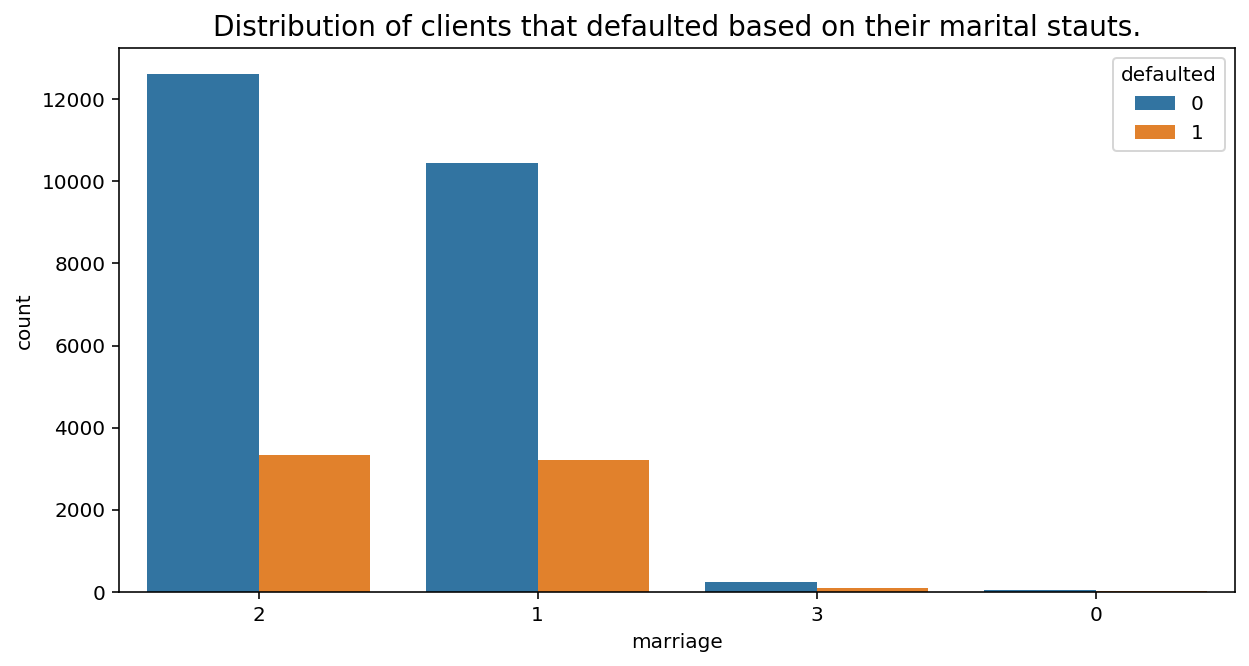

In [9]:
helpers.univ_bar(data=df_data, column='marriage', x_title='marriage', hue='defaulted', 
                 order=True, title="Distribution of clients that defaulted based on their marital stauts.")

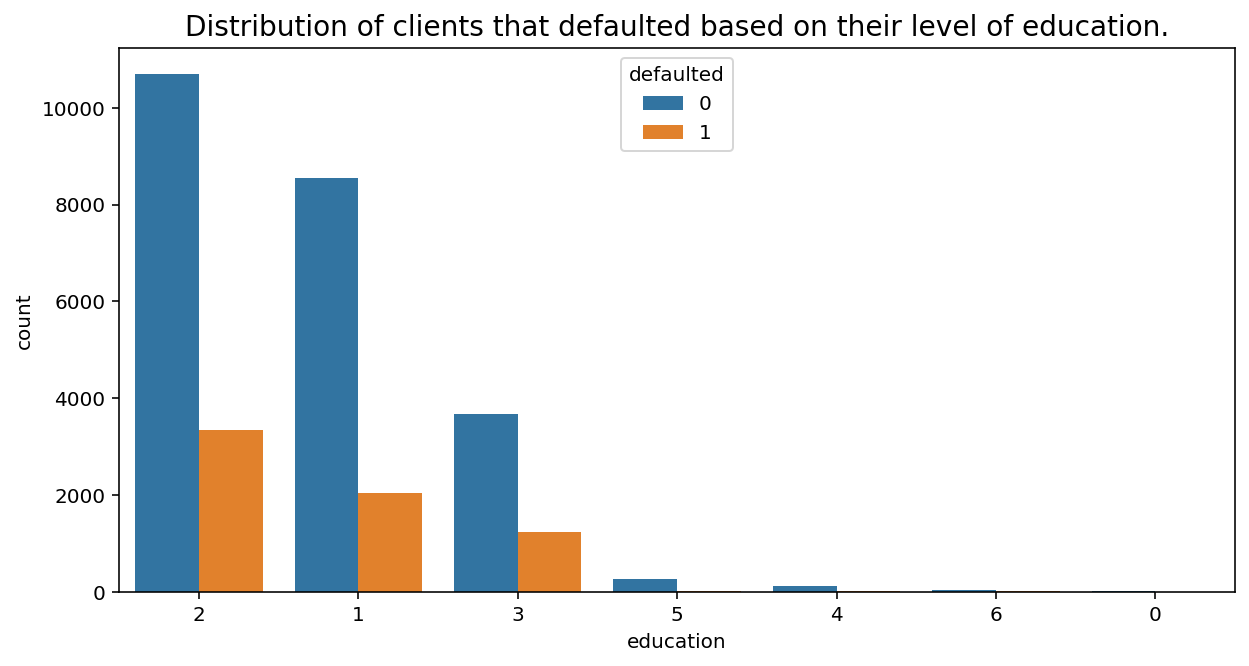

In [10]:
helpers.univ_bar(data=df_data, column='education', x_title='education', hue='defaulted', order=True, 
                 title="Distribution of clients that defaulted based on their level of education.")

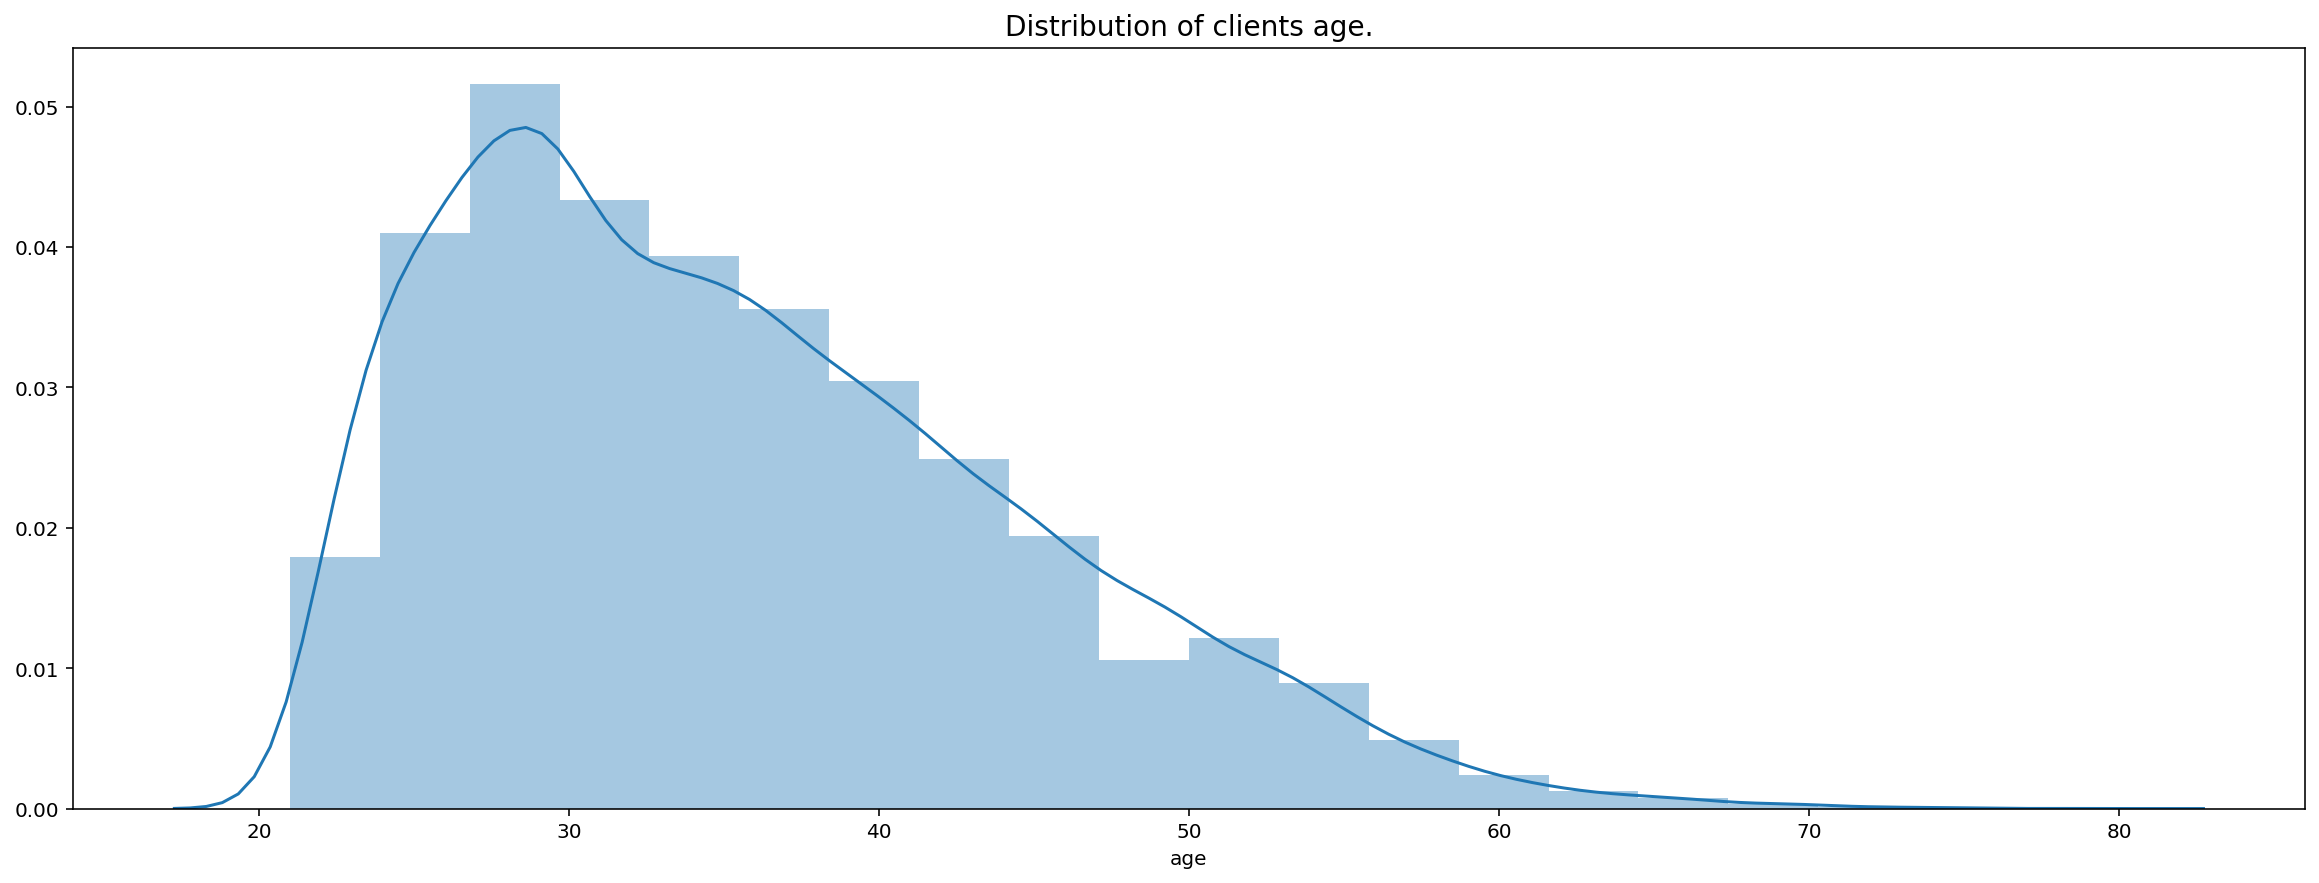

In [11]:
helpers.univ_hist(data=df_data, column='age', fig_w=20, bins=20, title="Distribution of clients age.")

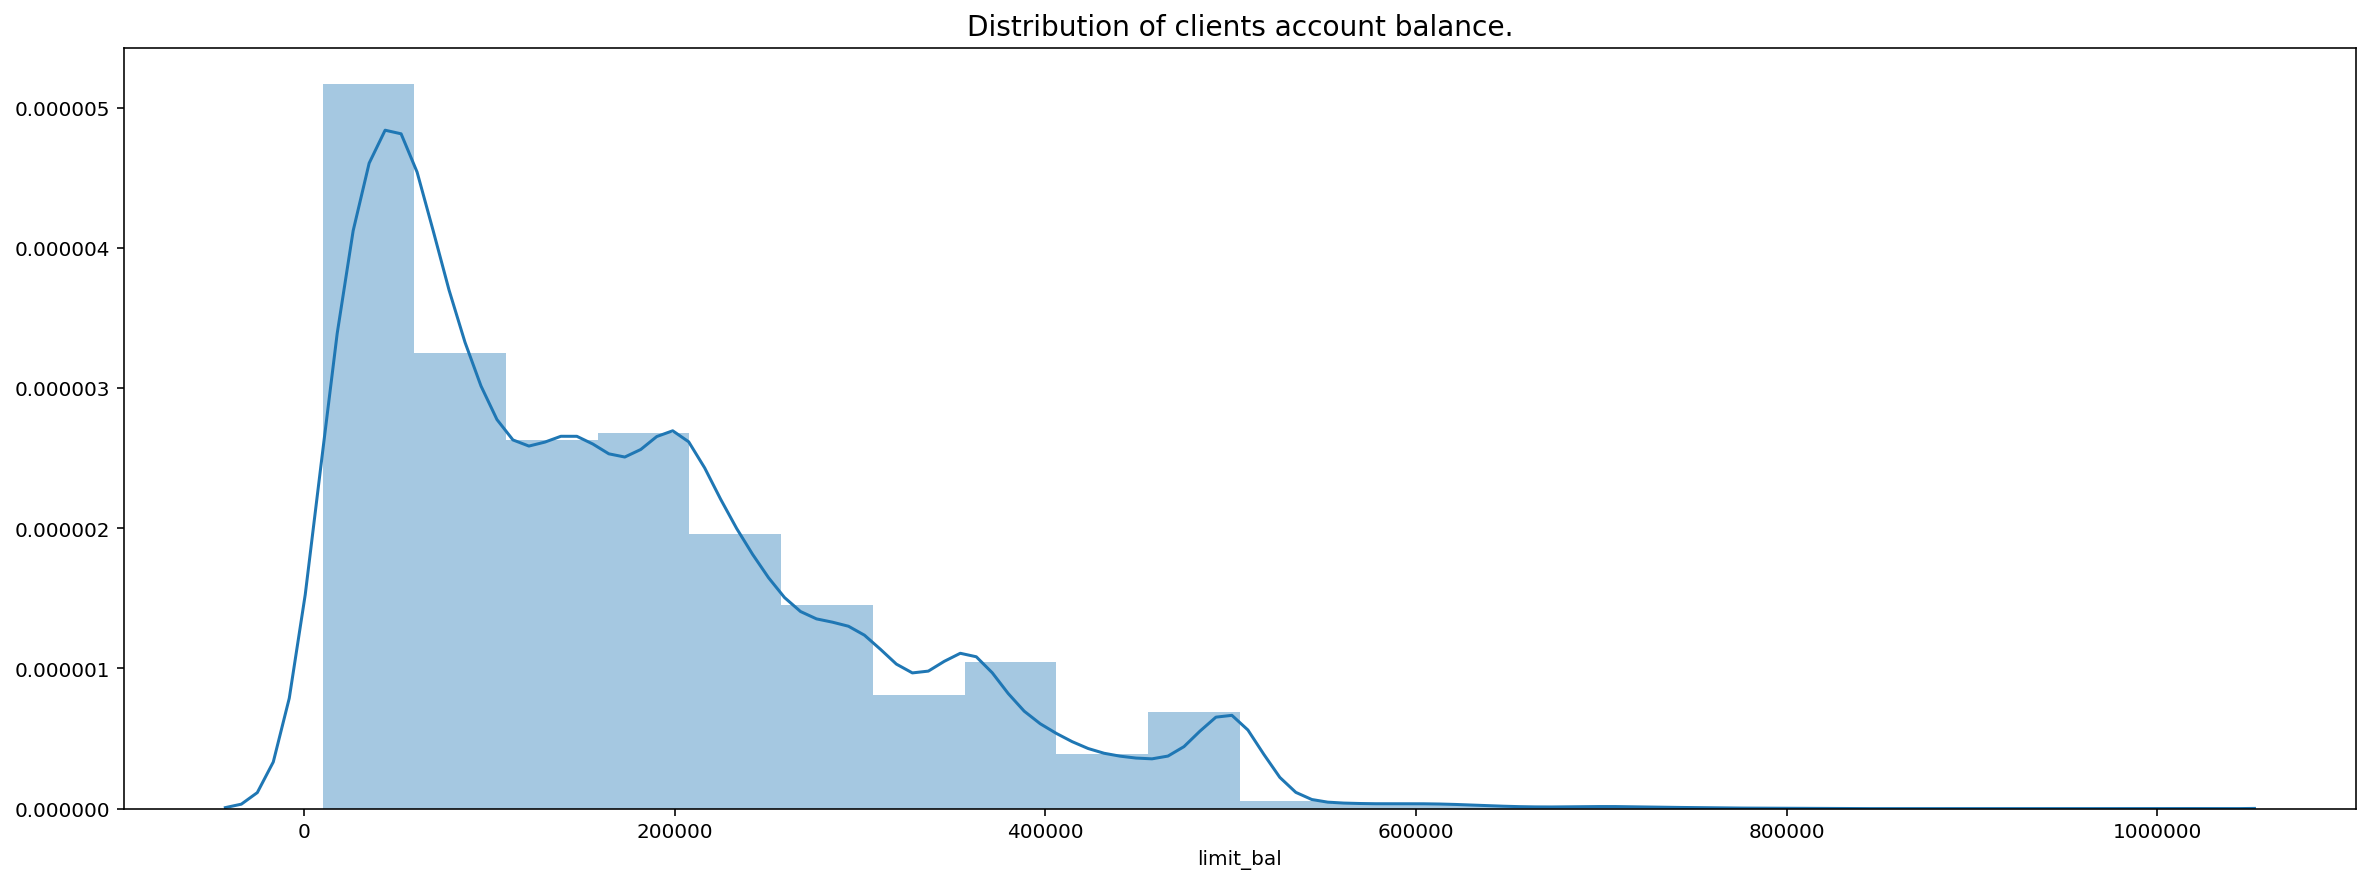

In [12]:
helpers.univ_hist(data=df_data, column='limit_bal', fig_w=20, bins=20, title="Distribution of clients account balance.")

<a id='be'></a>
### Bivariate Exploration

In this section, we investigate relationships between pairs of major variables **("limit_bal", "sex", "education", "marriage", "age")** and the financial status **("pay_1", "bill_amt1", "pay_amt1")** of clients accounts in the month of September in our data. 

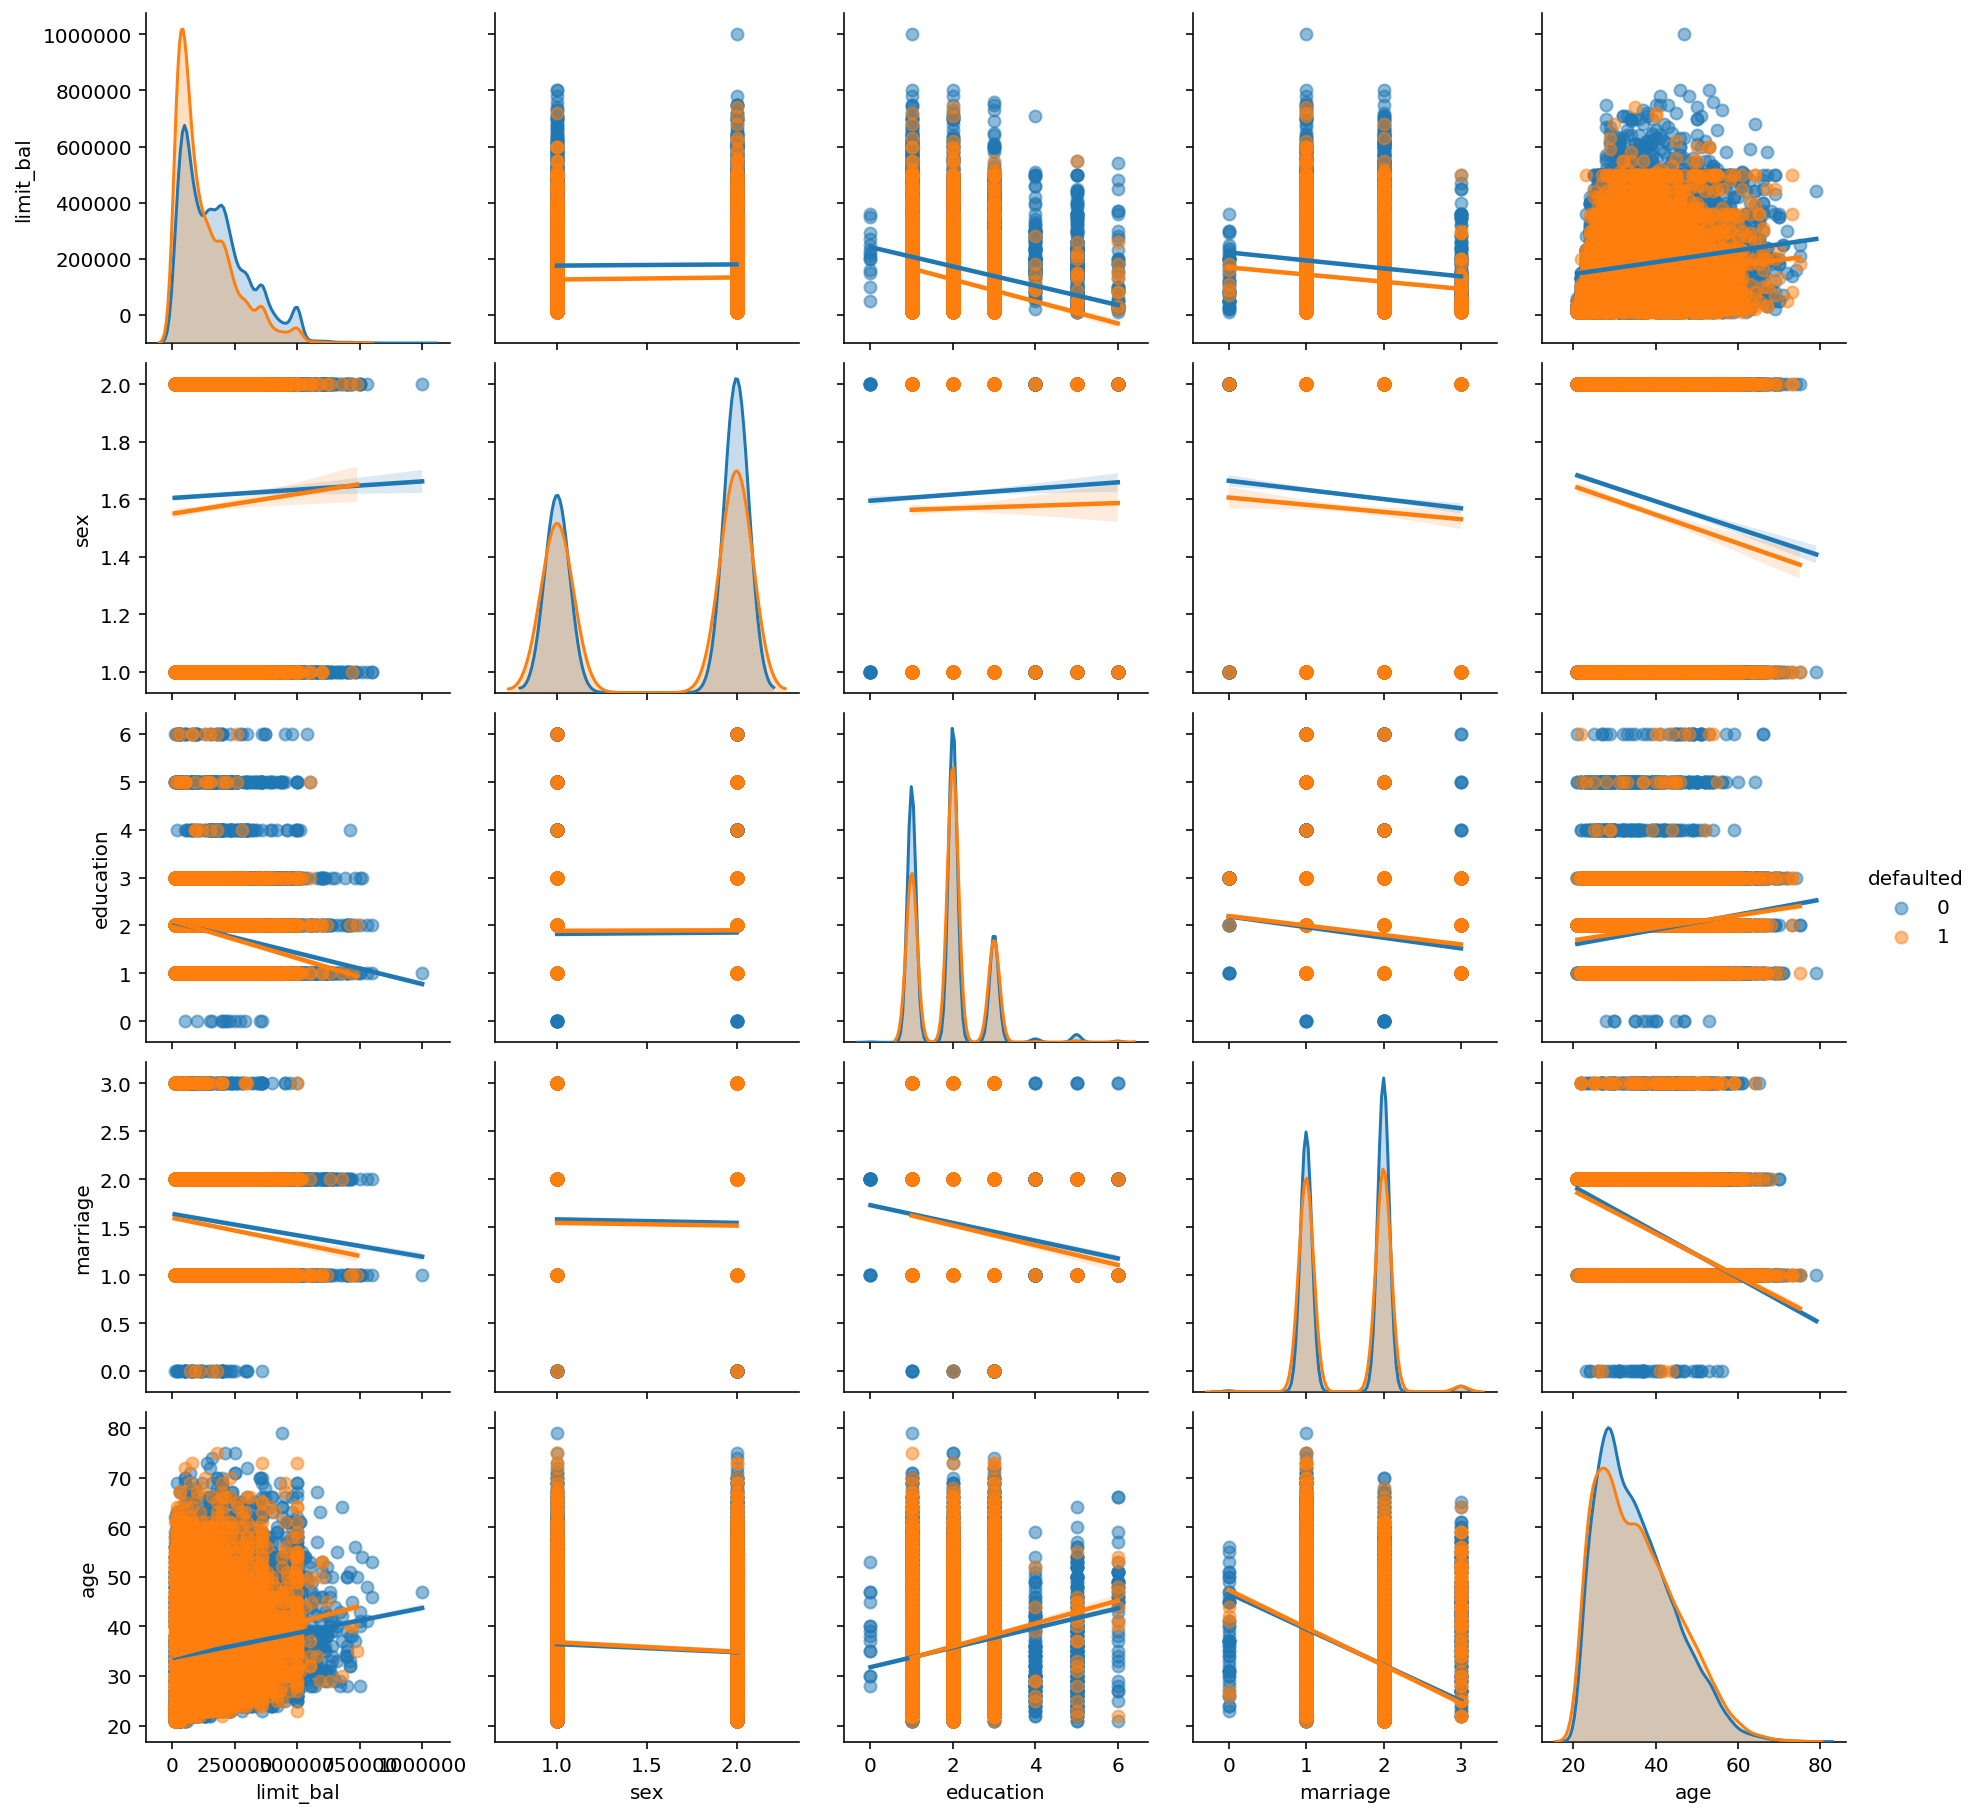

In [13]:
sns.pairplot(df_data, kind='reg', hue="defaulted", vars=['limit_bal', 'sex', 'education', 'marriage', 'age'], plot_kws={'scatter_kws': {'alpha': 0.5}})

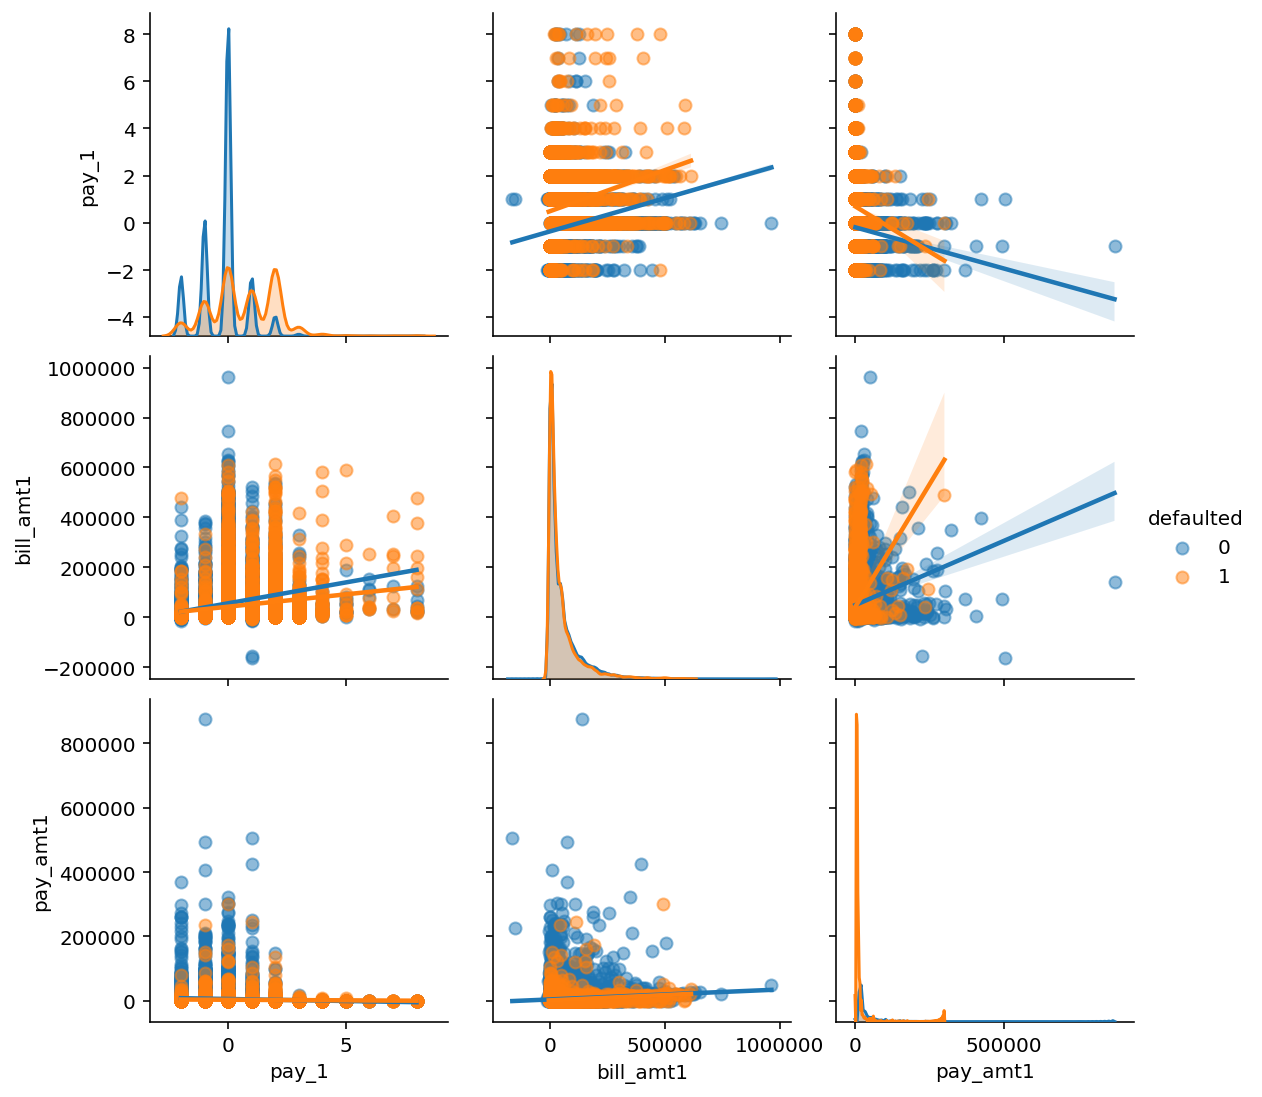

In [14]:
sns.pairplot(df_data, kind='reg', hue="defaulted", vars=['pay_1', 'bill_amt1', 'pay_amt1'], plot_kws={'scatter_kws': {'alpha': 0.5}})

**Observations:**

**...**


<a id='cmme'></a>
## Classification Models & Metrics Evaluation
<a id='dp'></a>
### Data Preparaion

In [15]:
# Split independent and target features 
independ_attrs, target_attrs = helpers.independ_target_attr_split(df_data)

# Split train and test data subsets
subsets = train_test_split(independ_attrs, target_attrs, test_size=0.1, random_state=0)

<a id='knn'></a>
### K Nearest Neighbors(KNN) Model
Now, we construct a KNN model, a classification that is computed from a simple majority vote of the nearest neighbors of each point: defaulted case is assigned to the data class which has the most representatives within the nearest neighbors of our obervation.

In [16]:
knn_pred, knn_true = knn.classfier(
    subsets=subsets, 
    n_neighbors = 7, 
    threshold = 0.35)

accuracy_score  : 0.73
precision_score : 0.36
recall_score    : 0.37
f1_score        : 0.37


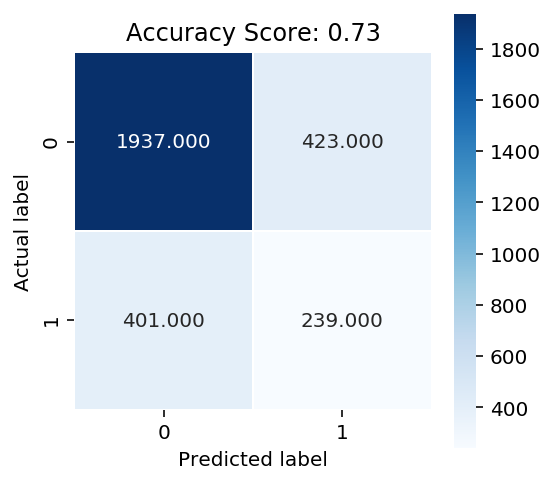

In [20]:
print("accuracy_score  : {:.2f}".format(metrics.accuracy_score(knn_true, knn_pred)))
print("precision_score : {:.2f}".format(metrics.precision_score(knn_true, knn_pred)))
print("recall_score    : {:.2f}".format(metrics.recall_score(knn_true, knn_pred)))
print("f1_score        : {:.2f}".format(metrics.f1_score(knn_true, knn_pred)))
helpers.confusion_matrix(true=knn_true, pred=knn_pred)

<a id='lg'></a>
### Logistic Regression Model

In [18]:
lg_pred, lg_true = lg.classfier(
    tol=0.000014,
    subsets=subsets, 
    data=df_data,
    solver='liblinear')

accuracy_score  : 0.81
precision_score : 0.68
recall_score    : 0.23
f1_score        : 0.35


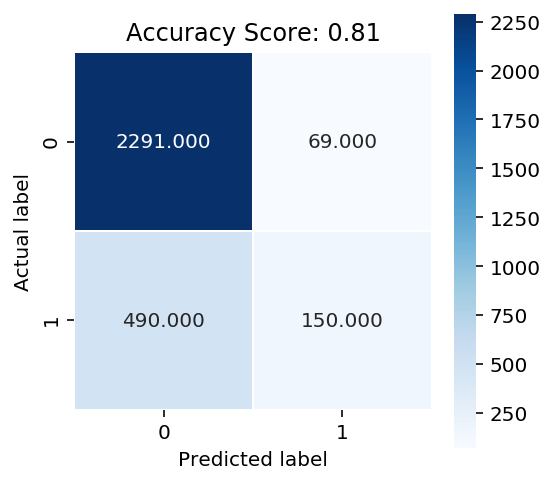

In [22]:
print("accuracy_score  : {:.2f}".format(metrics.accuracy_score(lg_true, lg_pred)))
print("precision_score : {:.2f}".format(metrics.precision_score(lg_true, lg_pred)))
print("recall_score    : {:.2f}".format(metrics.recall_score(lg_true, lg_pred)))
print("f1_score        : {:.2f}".format(metrics.f1_score(lg_true, lg_pred)))
helpers.confusion_matrix(true=lg_true, pred=lg_pred)

<a id='mlp'></a>
### Multi-layer Perceptron (MLP) Model

Now, we implement a **Multi-layer Perceptron (MLP)** classifier, supervised learning algorithm. Since it is sensitive to feature scaling, we scale the data as much as possible to suite for large-scale applications.

**...**

<a id='conclusion'></a>
## Conclusions


> **Warnings:** 
* This implementation is not intended for large-scale applications. In particular, scikit-learn offers no GPU support. For much faster, GPU-based implementations, as well as frameworks offering much more flexibility to build deep learning architectures, see [Related Projects](https://scikit-learn.org/stable/related_projects.html#related-projects).
* Currently, MLPClassifier supports only the Cross-Entropy loss function


**...**